In [1]:
import collections
from collections import OrderedDict
import pandas as pd
import time as tm

In [2]:
run -i "windows_door_algorithm.py"

In [3]:
data_size = 500
compressor = WindowsDoorCompression(data_size)

In [4]:
df = pd.read_csv('data/sample1.csv', parse_dates=True, index_col=0)
df['Counter'] = df['Counter'].astype(float)
data = {}
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

for index, row in df.iterrows():
    data[index] = row['Counter']

In [5]:
t0 = tm.time()

exception = compressor._run_exception(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(exception)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(exception), "data points remaining"))

1549753146.650929  seconds time elapsed in running exception.
1549753146.714467  seconds time elapsed in running exception.
0.0635380744934082  seconds time elapsed in running exception.
5960 number of data points discarded as part of exception window
510 data points remaining


In [6]:
exception_modified = {}

for time, value in exception.items():
    exception_modified[time] = [time, value]

exception_df = pd.DataFrame.from_dict(exception_modified, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

In [7]:
t0 = tm.time()

compression = compressor._run_compression(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(compression)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(compression), "data points remaining"))

1549753157.052993  seconds time elapsed in running exception.
1549753161.693643  seconds time elapsed in running exception.
4.640650033950806  seconds time elapsed in running exception.
5937 number of data points discarded as part of exception window
533 data points remaining


In [8]:
compression_modified = {}

for time, value in compression.items():
    compression_modified[time] = [time, value]
    
compression_df = pd.DataFrame.from_dict(compression_modified, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

In [10]:
t0 = tm.time()

hybrid = compressor._run_hybrid(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(hybrid)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(hybrid), "data points remaining"))

1549753193.178826  seconds time elapsed in running exception.
1549753197.639908  seconds time elapsed in running exception.
4.4610819816589355  seconds time elapsed in running exception.
5937 number of data points discarded as part of exception window
533 data points remaining


In [11]:
hybrid_modified = {}

for time, value in hybrid.items():
    hybrid_modified[time] = [time, value]
    
hybrid_df = pd.DataFrame.from_dict(hybrid_modified, orient='index')
hybrid_df.columns = ['Date', 'Counter']
hybrid_df.set_index('Date', inplace=True)

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'inf', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


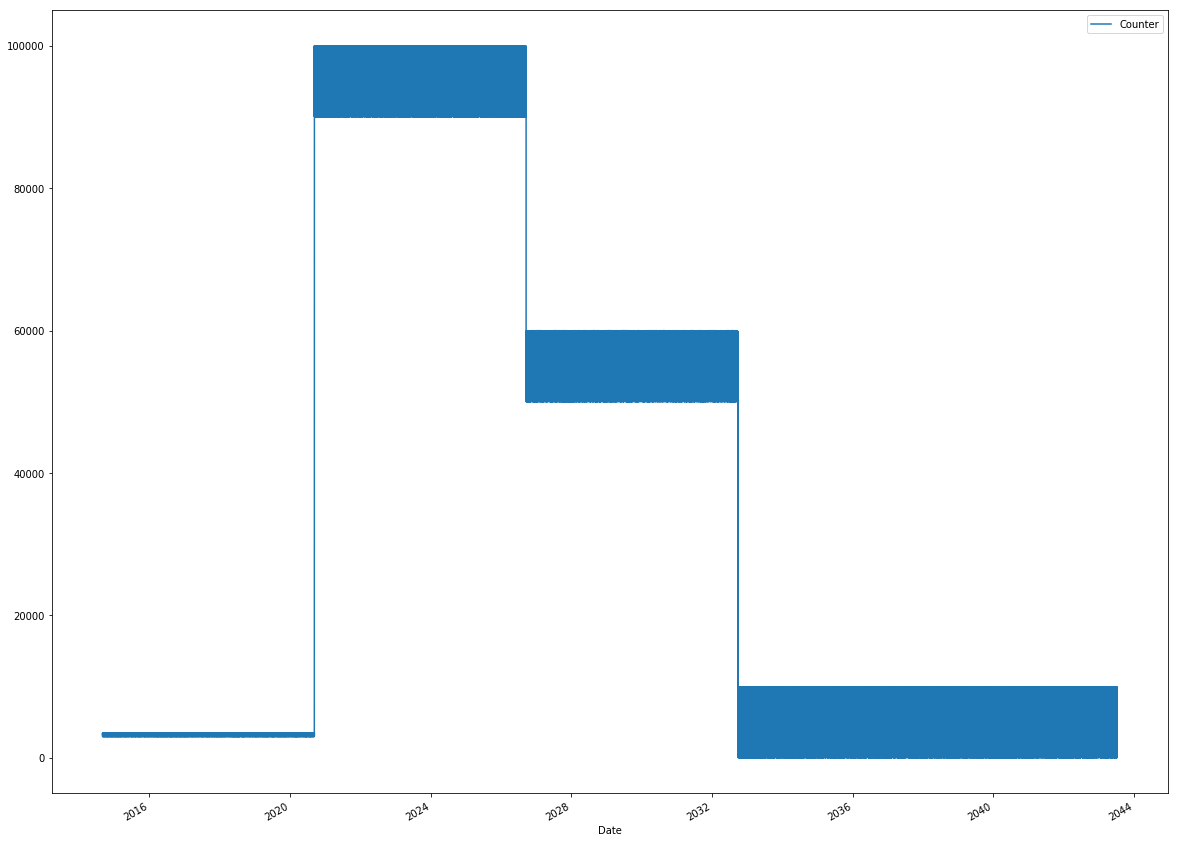

In [11]:
%pylab inline
rcParams['figure.figsize'] = [20, 16]
df.plot()

Populating the interactive namespace from numpy and matplotlib


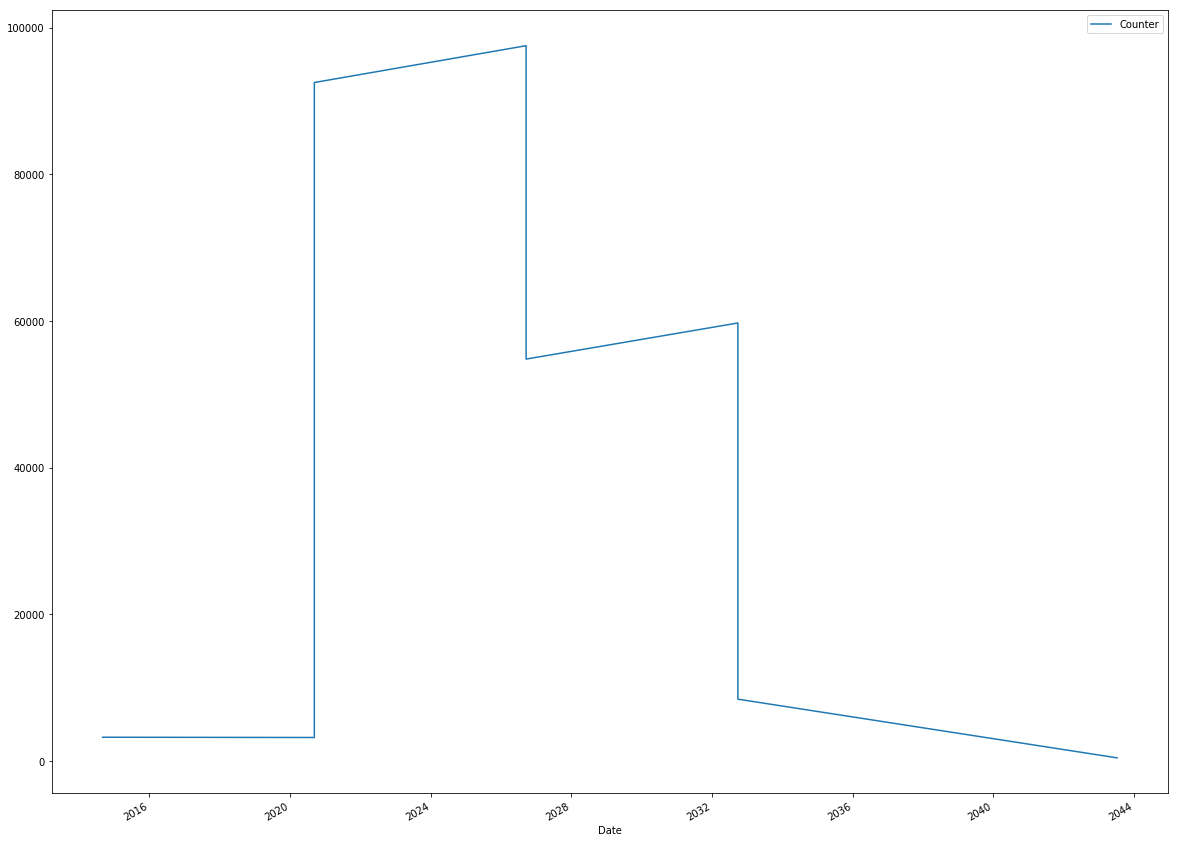

In [12]:
%pylab inline
rcParams['figure.figsize'] = [20, 16]
exception_df.plot()

In [ ]:
%pylab inline
rcParams['figure.figsize'] = [20, 16]
compression_df.plot()

Populating the interactive namespace from numpy and matplotlib


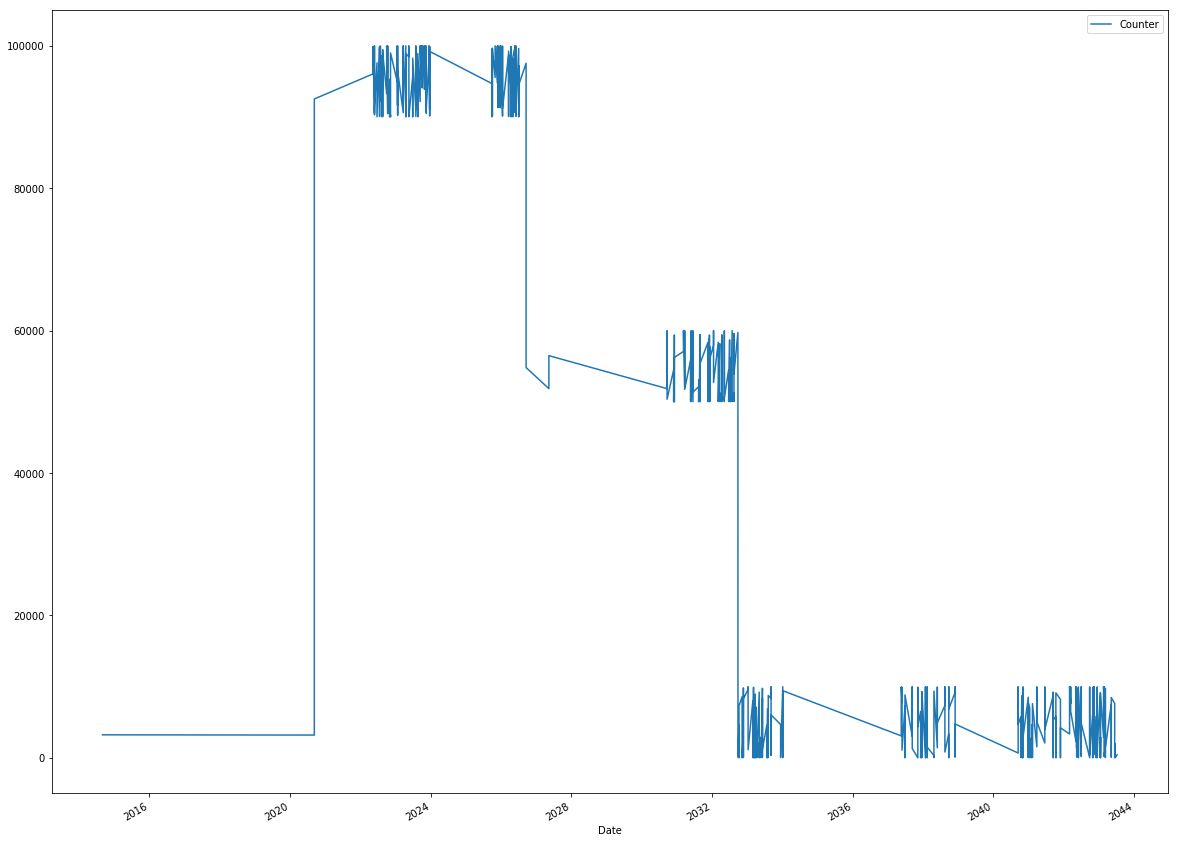

In [13]:
%pylab inline
rcParams['figure.figsize'] = [20, 16]
hybrid_df.plot()